<a href="https://colab.research.google.com/github/KevinMartinez1999/Machine_Learning/blob/develop/K_Means_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN_16QAM Modulation

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sofa import demapper_sym, SymbolErrorRate, BitErrorRate, sync_signals
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Generación y modulación

In [189]:
Ns = 100000
Mod = 16 #16QAM
y = np.random.randint(Mod, size = Ns)
y = np.sort(y)
df_sym_tx = pd.DataFrame(np.transpose(y), columns = ['data'])
df_sym_tx.head()

,data
0,0
1,0
2,0
3,0
4,0


In [190]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [191]:
#Modulación reemplazando símbolos por valores complejos (opción 1)
df_sym_mod = df_sym_tx.replace(mod_dict)
df_sym_mod.head()

,data
0,-3.0+3.0j
1,-3.0+3.0j
2,-3.0+3.0j
3,-3.0+3.0j
4,-3.0+3.0j


In [192]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(5)

0   -3.0+3.0j
1   -3.0+3.0j
2   -3.0+3.0j
3   -3.0+3.0j
4   -3.0+3.0j
Name: data, dtype: complex128

### Transmision canal AWGN

In [193]:
Xr = np.real(df_sym_mod['data'])
Xi = np.imag(df_sym_mod['data'])

In [194]:
# Adición de ruido blanco Gaussiano (AWGN)
# Se le adiciona diferentes cantidades de ruido para ver los efectos de 
# este en la demodulación.

target_snr_db = [i for i in np.arange(0, 33, 4)]
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
#noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
noise_r= [np.random.normal(mean_noise, np.sqrt(i), len(Xr)) for i in noise_avg_p_r]
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
#noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
noise_i = [np.random.normal(mean_noise, np.sqrt(i), len(Xi)) for i in noise_avg_p_i]
Xi_ch = Xi + noise_i

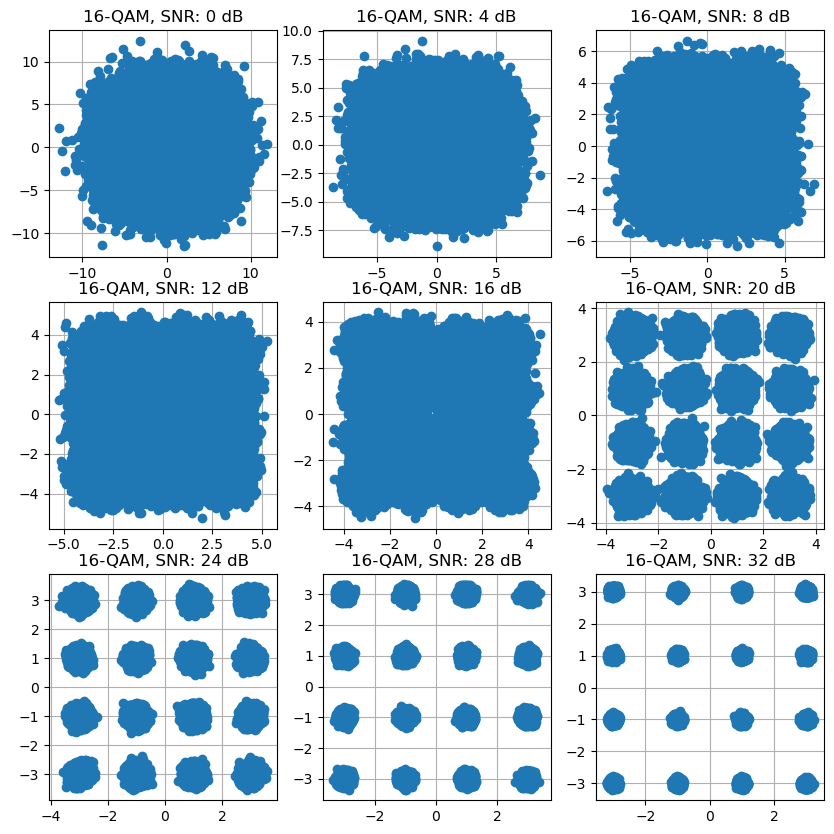

In [195]:
plt.figure(figsize = (10, 10))

for i in range(len(target_snr_db)):
  plt.subplot(3, 3, i + 1)
  plt.title('16-QAM, SNR: '+str(target_snr_db[i])+' dB')
  plt.plot(Xi_ch[i], Xr_ch[i], 'o')
  plt.grid()
plt.show()

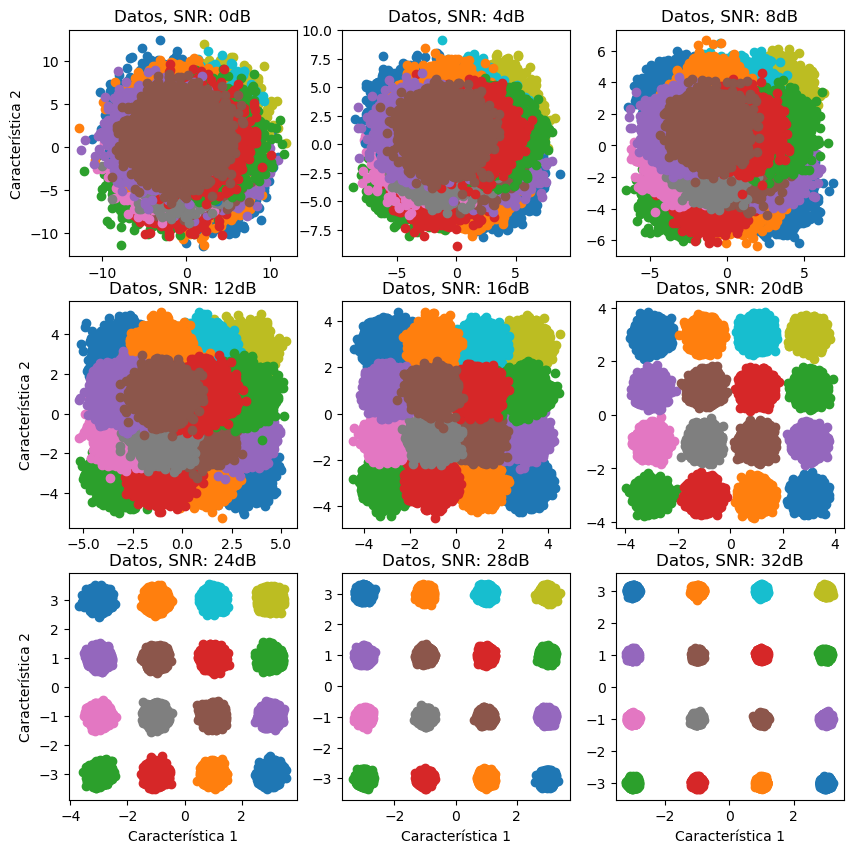

In [196]:
plt.figure(figsize=(10, 10))

for i in range(len(target_snr_db)):
  plt.subplot(3, 3, i + 1)
  plt.title(f'Datos, SNR: {target_snr_db[i]}dB')
  for g in np.unique(y):
      ix = np.where(y == g)
      plt.plot(Xi_ch[i][ix], Xr_ch[i][ix], 'o', label = g)
  #plt.legend(loc = 'upper right')
  if i + 1 >= 7:
    plt.xlabel('Característica 1')
  if (i + 1 == 1) or (i + 1 == 4) or (i + 1 == 7):
    plt.ylabel('Característica 2')

plt.show()

### Demodulación

In [197]:
#sym_rx = demapper_sym(Xr_ch[0], Xi_ch[0], len(Xr_ch[0]), threshold = 2.0)
sym_rx = [demapper_sym(Xr_ch[i], Xi_ch[i], len(Xr_ch[i]), threshold = 2.0) for i in range(len(target_snr_db))]
print(f'SNR {target_snr_db[0]}dB :', sym_rx[0][0:10])
print(f'SNR {target_snr_db[3]}dB:', sym_rx[3][0:10])
print('Original:', y[0:10])

SNR 0dB : [1, 0, 4, 0, 0, 0, 7, 4, 1, 0]
SNR 12dB: [0, 0, 0, 1, 0, 0, 0, 4, 0, 0]
Original: [0 0 0 0 0 0 0 0 0 0]


In [198]:
arr_SER = []
for i in range(len(target_snr_db)):
  SER, error = SymbolErrorRate(sym_rx[i], y)
  arr_SER.append(SER)
  print(f'SER {target_snr_db[i]}dB:', SER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.74128
Error 0dB: 74128 

SER 4dB: 0.58998
Error 4dB: 58998 

SER 8dB: 0.35429
Error 8dB: 35429 

SER 12dB: 0.10923
Error 12dB: 10923 

SER 16dB: 0.0068
Error 16dB: 680 

SER 20dB: 0.0
Error 20dB: 0 

SER 24dB: 0.0
Error 24dB: 0 

SER 28dB: 0.0
Error 28dB: 0 

SER 32dB: 0.0
Error 32dB: 0 



In [199]:
arr_BER = []
for i in range(len(target_snr_db)):
  BER, error = BitErrorRate(sym_rx[i], y)
  arr_BER.append(BER)
  print(f'SER {target_snr_db[i]}dB:', BER)
  print(f'Error {target_snr_db[i]}dB:', error, '\n')

SER 0dB: 0.28867
Error 0dB: 115468 

SER 4dB: 0.18804
Error 4dB: 75216 

SER 8dB: 0.098365
Error 8dB: 39346 

SER 12dB: 0.0280325
Error 12dB: 11213 

SER 16dB: 0.0017025
Error 16dB: 681 

SER 20dB: 0.0
Error 20dB: 0 

SER 24dB: 0.0
Error 24dB: 0 

SER 28dB: 0.0
Error 28dB: 0 

SER 32dB: 0.0
Error 32dB: 0 



### Demodulación usando DBSCAN

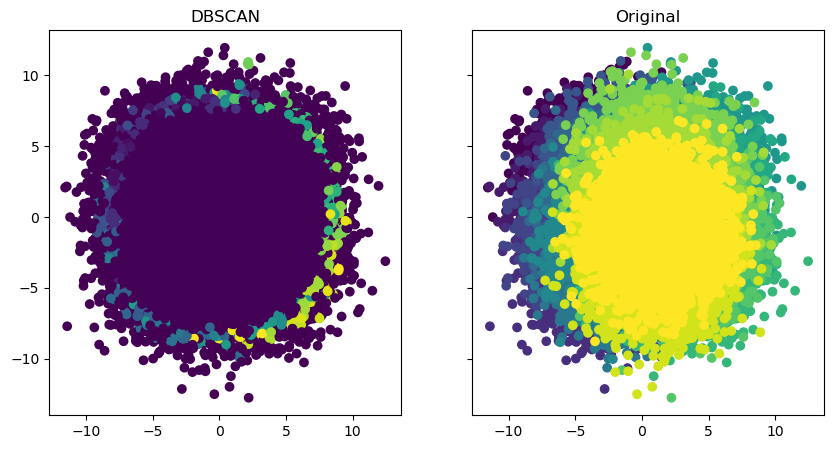

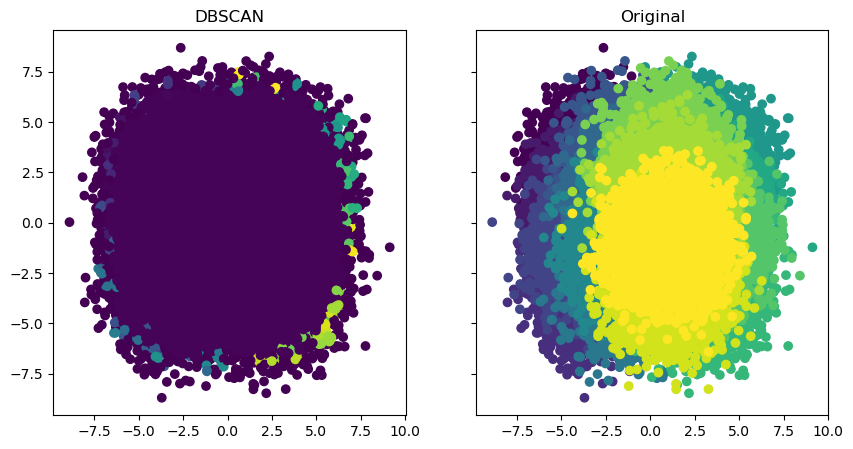

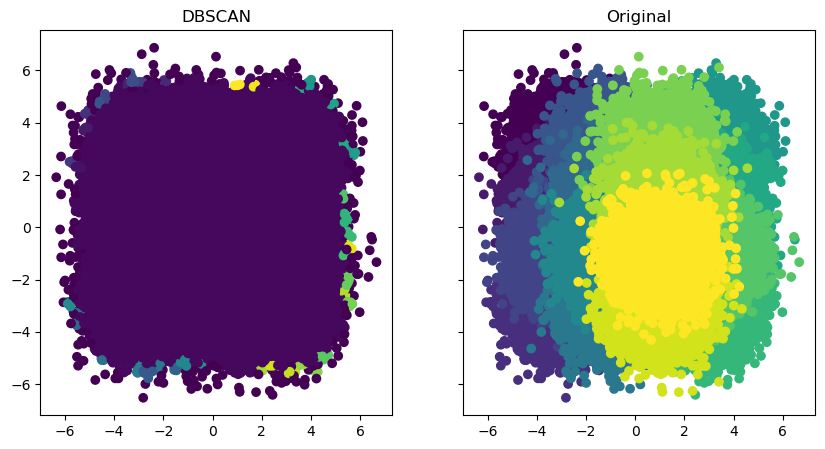

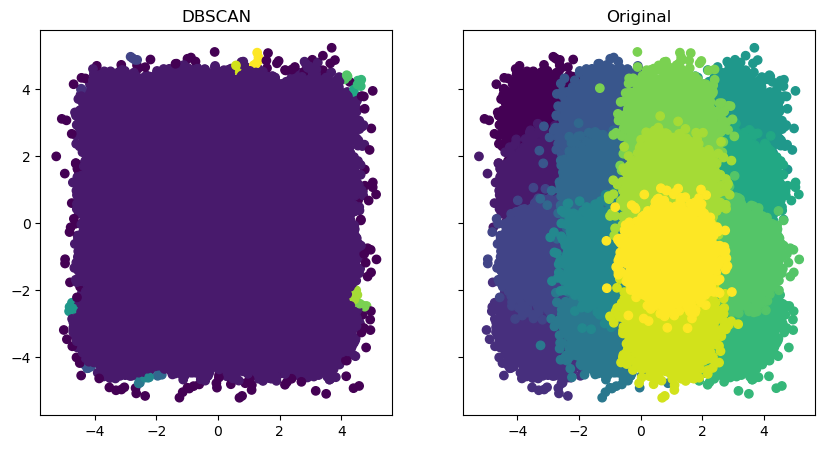

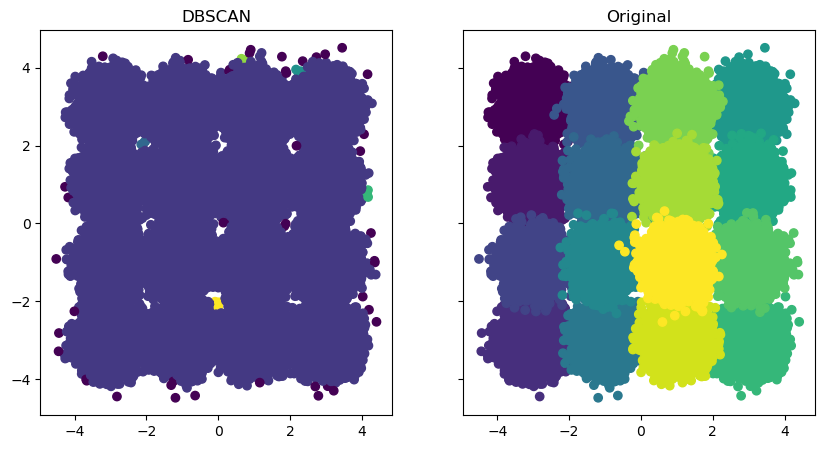

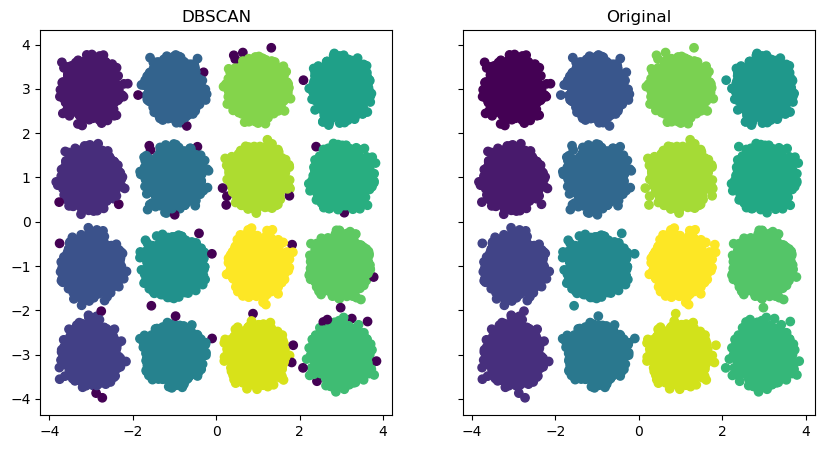

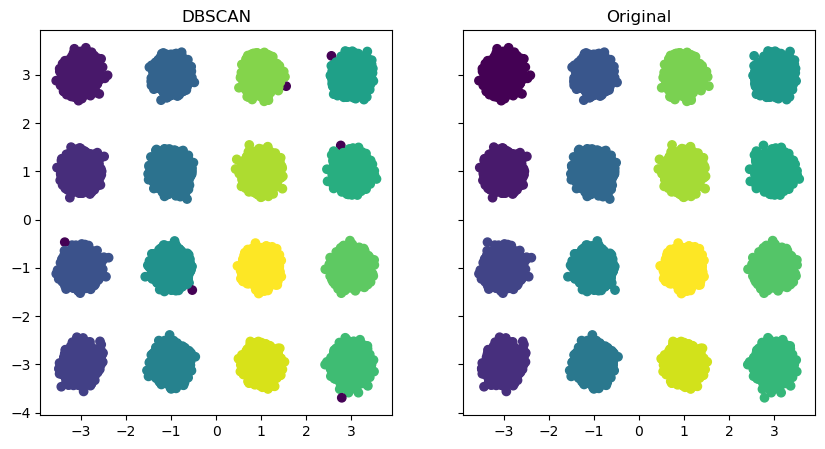

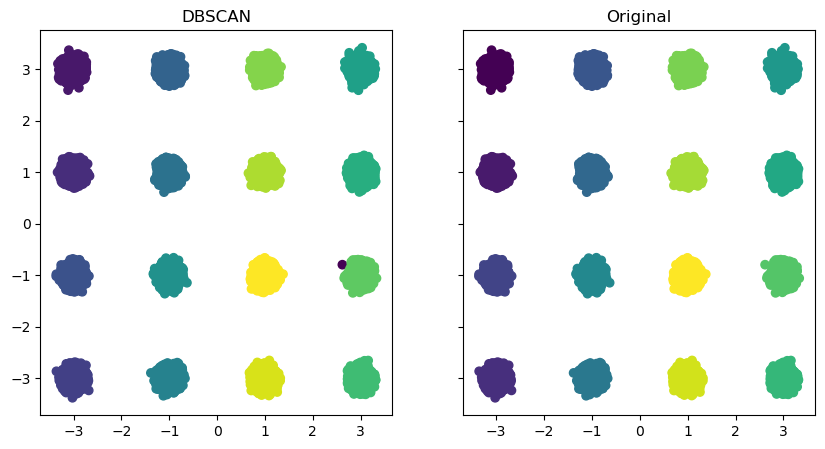

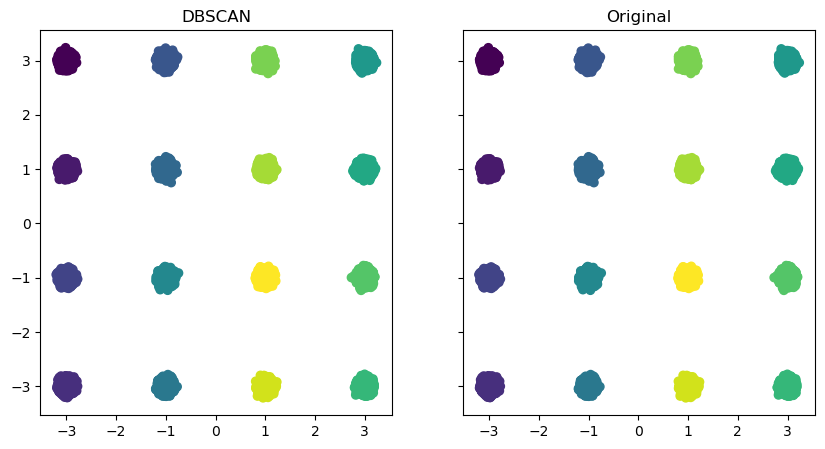

In [200]:
arr_BER_dbscan = []
for i in range(len(target_snr_db)):
  X = np.transpose(np.array([Xr_ch[i], Xi_ch[i]]))

  model = DBSCAN(eps = 0.15, min_samples = 3).fit(X)

  #SER_test, error_SER = SymbolErrorRate(model.labels_, y)
  #print(f'SER: {SER_test}, Error sym: {error_SER}')

  BER_test, error_BER = BitErrorRate(model.labels_, y)
  #print(f'BER: {BER_test}, Error Bit: {error_BER}')

  arr_BER_dbscan.append(BER_test)

  fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10, 5))
  ax1.set_title('DBSCAN')
  ax1.scatter(X[:, 0], X[:, 1], c = model.labels_)
  ax2.set_title('Original')
  ax2.scatter(X[:, 0], X[:, 1], c = y)

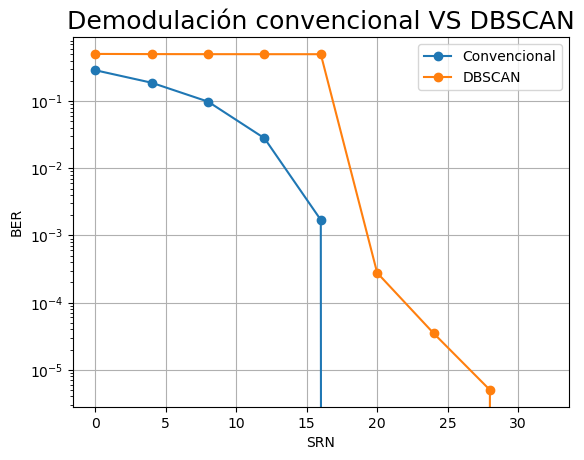

In [201]:
plt.title('Demodulación convencional VS DBSCAN', fontsize = 18)
plt.plot(target_snr_db, arr_BER[:], marker = 'o', label = 'Convencional')
plt.plot(target_snr_db, arr_BER_dbscan, marker = 'o', label = 'DBSCAN')
plt.xlabel('SRN')
plt.ylabel('BER')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()